In [1]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import COBYLA
import numpy as np 
from numpy import sqrt, pi, linalg
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit import Aer, transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, PauliOp

**General Ansatz Generator**


In [3]:
# Prepare general State Circuit (n Qubit)-Multicontrol qubit
def PrepareState_Gen(parameter,q = 2):
    # Multi control U3 gate
    def MCUGate(p1,p2,ctrlqubit):
        ctrl = QuantumCircuit(1, name='U3')
        # U3 decompose
        ctrl.rz(p2,0)
        ctrl.rx(-np.pi/2,0)
        ctrl.rz(p1,0)
        ctrl.rx(np.pi/2,0)
        ctrl.rz(-p2,0)
        # U3 decompose
        ctrl = ctrl.to_gate().control(ctrlqubit)
        return ctrl

    # State's bit string converter
    def Bitstring(inter,leng):
        result = []
        while inter >= 2:
            d = inter % 2
            inter = inter//2
            result.append(d)
        result.append(inter)
        for i in range(leng-len(result)):
            result.append(0)
        return result
        
    # Generate general ansatz circuit
    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    qc.u(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    # Apply multi-control qubit gate
    for i in range(q-1):
        listctrl = [ i+n+1 for n in range(q-i-1)]
        listctrl.append(i)
        for j in range(2**(q-i-1)):
            bitstring = Bitstring(j,q-i-1)
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1)
            qc.append(MCUGate(parameter[theta],parameter[theta+1],q-i-1),listctrl) 
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1) 
            theta +=2
        qc.barrier(range(q))
    return qc

**General Ansatz**

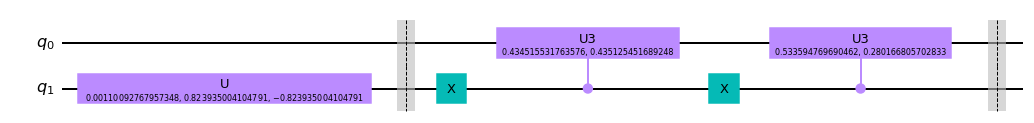

In [4]:
q = 2

parameters = ParameterVector('θ', 2**(q+1)-2)
param_dict = {parameter: np.random.random() for parameter in parameters}

State = PrepareState_Gen(parameters,q)
State = State.assign_parameters(parameters = param_dict)
State.draw(output='mpl')

**Ising Hamiltonian Operator**

In [5]:
def Ising_Hamilton(q,h):
    Ising_Hamilton = 0
    for i in range(q):
        Zterm  = 1
        Xterm  = 1
        for j in range(q-1):
            if j == i:
                Zterm = Zterm^Z^Z
                Xterm  = Xterm^X^I
            elif i == (q-1) and j == (i-1):
                Xterm = Xterm^I^X
                Zterm = 0
            else:
                Zterm = Zterm^I
                Xterm = Xterm^I
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

**Classical running**

In [6]:
# Classical running
q = 2
cvalue = []
hvalue = []


for i in range(20):
    h = i/10
    hvalue.append(h)
    op = Ising_Hamilton(q,h) 

    # Classical solver
    w,v = np.linalg.eig(Operator(op))
    minimum=w[0]
    min_spot=0
    for i in range(1,2**q):
        if w[i]<minimum:
            min_spot=i
            minimum=w[i]                   
    groundstate = v[:,min_spot]
    cvalue.append(minimum)

**VQE (using Qiskit function) running**

In [7]:
# Array value
newhvalue = []
Gen_value = []

# Callback data
counts = []
values = []
params = []
deviation = []
def callback(eval_count, parameters, mean, std):  
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

# Backend and Optimizer
optimizer = COBYLA(maxiter=1000)
backend = Aer.get_backend('qasm_simulator')
seed = 132     #set random seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=20000)

In [8]:
for i in [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8]:
    h = i
    newhvalue.append(h)
    op = Ising_Hamilton(q,h) 
    
    # Paramerized General Ansatzs
    parameter = ParameterVector('θ', 2**(q+1)-2)
    Gen_ans = PrepareState_Gen(parameter,q)

    # Instantiate randomly value of parameters
    parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(Gen_ans.num_parameters)]
    
    # VQE Qiskit running
    vqer = VQE(Gen_ans,optimizer=optimizer,quantum_instance=quantum_instance, initial_point=parameters,callback=callback)
    result = vqer.compute_minimum_eigenvalue(op)
    Gen_value.append(result.optimal_value)

**Result Visualization**

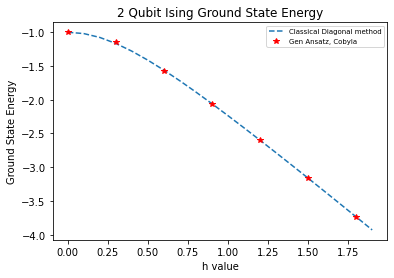

In [10]:

plt.plot(hvalue, cvalue, '--',label='Classical Diagonal method')
plt.plot(newhvalue, Gen_value, 'r*',label='Gen Ansatz, Cobyla')

plt.legend(loc='best',fontsize='x-small')

plt.title('2 Qubit Ising Ground State Energy')
plt.ylabel('Ground State Energy')
plt.xlabel('h value')
plt.show()